# Supervised Learning Project

## __Project Topic__

This project is a movie recommendation system based on collaborative filtering using user-item and item-item collaborative filtering, implemented through two separate k-nearest-neighbors algorithms. 

The user-item predictive model will use KNN regression, while the item-item model will use a simple neighbor search followed by a weighted average. The performance of these models will be evaluated based on their predictive ability for a group of movie ratings, with RMSE (Root-Mean-Squared-Error) and RAE (Random-Absolute-Error) being the metrics used for evaluating them.

 There will also be attempts to test the importance of some features within the base models, by normalizing user reviews and add weighting based on movie counts. Hyperparameter tuning of the number of neighbors will also be performed.


#### Purpose

My goal with creating this system is to create a system that can do two main kind of predictions, based on user preference, and movie similarity:

-When given a user profile, accurately predict said user's ratings for movies based on their similarity to other users.

-When given a movie, output relevant recommendations based on the similarities of movies ("If you liked that, you might like this"). This is often evaluated based off how closely a weighted average of similar movies rated compare to the original movies' rating.

I've personally been getting into movies lately, and would like my own homemade way of determining new things to watch.

In [70]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix,diags
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

## __Data__

The dataset used for this project is the MovieLens 10m dataset, which contains approximately 10,000,000 ratings and 95,0000 tags, applied to 10,000 movies by 71,000 users. The relevant paper and DOI can be found in the references section at the end of the notebook. 

This project focuses entirely on the "ratings" file of the MovieLens dataset, and uses the "movies" file as an accompanying lookup file. 

In [396]:
dir = "C:/ml-10m/ml-10M100K/" 
# importing the data
movies = pd.read_csv(dir + "movies.dat",delimiter="::")
ratings = pd.read_csv(dir + "ratings.dat",delimiter = "::")

#fitting relevant column names to the data
ratings.columns = ['userId','movieId','rating','timestamp']
movies.columns = ["movieId","title","genres"]


C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\3893096089.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv(dir + "movies.dat",delimiter="::")
C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\3893096089.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(dir + "ratings.dat",delimiter = "::")


#### Cleaning

The MovieLens 10m dataset is already quite clean. 
It contains no missing values, all rows contain the same datatype, and it contains no duplicates. There are no unexpected values that 

That being said, it is still possible for outliers to manifest within the data the average rating of users. 

If a user on average rates movies very high or very low, it could be an indication of spam or fake reviews. As such, if there are relatively few users who fit this criteria, they will be removed from the dataset. It could be feasible to impute these users' ratings with the average ratings for each movie, but doing so may also introduce unnecessary bias to the users' data (Ex. an account that previously rated everything poorly now matches a user's profile due to imputing, and user now gets recommendations influenced by this). 

Users whose ratings' have a standard deviation of 0 will also be removed, as this also a reasonable indicator of dishonesty, and they cannot be scaled via their standard deviation. Imputation could potentially be performed with the same approach as previously stated, but will also be avoided if possible for the same reason as before.

At the start of this process we group users by their id, and calculate the mean for each userId.

In [ ]:
#groupby user ids, and average ratings into new array
avg_user_ratings = ratings.groupby("userId")["rating"].mean()

In [ ]:
# show statistical information of users' average ratings
print(avg_user_ratings.describe())

count    69878.000000
mean         3.613641
std          0.428244
min          0.500000
25%          3.360000
50%          3.634615
75%          3.900000
max          5.000000
Name: rating, dtype: float64


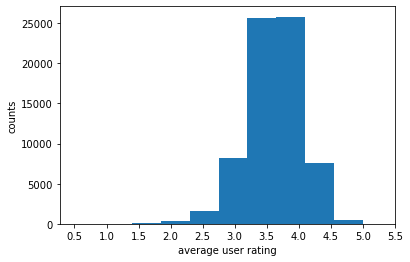

In [ ]:
#plot histogram of users' average ratings
plt.hist(avg_user_ratings)
bins = np.arange(0.25,5.75,0.5)
plt.xticks(bins+0.25)
plt.ylabel("counts")
plt.xlabel("average user rating")
#plt.xlim(0,5)
plt.show()

The average average user rating turns out to be 3.6, which is reasonable. The 50th percentile is also about 3.6.

According to the data presented above, there do appear to be users present in the data with average ratings of both 5, and 0.5, having rating nothing else as such.

In light of this, I will remove users that lie within one "tick" of the rating system (0.5) from either extreme. If the loss is too high,or it alters general parameters too greatly, I may need to impute it after all, or scale it back.

In [ ]:
user_range = np.logical_and(avg_user_ratings < 4.5, avg_user_ratings > 1)
avg_user_ratings_adj = avg_user_ratings[user_range]
print("% of users lost removing users with avg rating higher than 4.5 and lower than 1: {:.2f}% of users lost"
      .format(100* (1-len(avg_user_ratings_adj)/len(avg_user_ratings))))


% of users lost removing users with avg rating higher than 4.5 and lower than 1: 1.16% of users lost


In [ ]:
users_idx = user_range.index[user_range]
ratings_filtered = ratings[ratings["userId"].isin(users_idx)]
print("% of ratings lost by removing users with avg rating higher than 4.5 and lower than 1: {:.2f}% of ratings lost"
      .format(100* (1-len(ratings_filtered)/len(ratings))))

% of ratings lost by removing users with avg rating higher than 4.5 and lower than 1: 0.61% of ratings lost


In [ ]:
avg_user_ratings_adj.describe()

count    69065.000000
mean         3.602366
std          0.415076
min          1.033333
25%          3.356589
50%          3.629032
75%          3.889535
max          4.496815
Name: rating, dtype: float64

This extreme behavior only seemed to compose 1.16% of the users, and 0.61% of the data, which I think is an acceptable loss to the dataset. The mean and 50th percentile also remained largely the same, so this cleaned data seems viable to use for the rest of the project.

It's interesting to note that based on these metrics, these users profiles have about half as many ratings as the average user, since if these were sampled randomly, we would expect losing 1.2% of users would naturally equate to losing 1.2% of ratings. This can be another indicator that these are a group of accounts that were made solely to provide certain movies with certain reviews, and nothing more.

This same process will now be repeated for standard deviation. The process is the same, but with a different metric.

In [ ]:
#groupby user ids, and put standard deviations into new array
std_user_ratings = ratings.groupby("userId")["rating"].std()
std_user_ratings.describe()

count    69878.000000
mean         0.960400
std          0.224584
min          0.000000
25%          0.803192
50%          0.939822
75%          1.096647
max          2.308451
Name: rating, dtype: float64

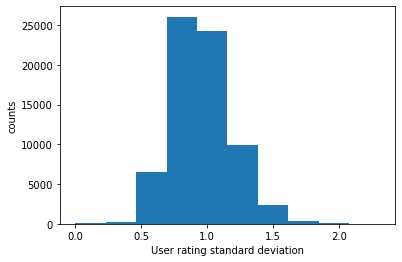

In [ ]:
#plot histogram of users' average ratings
plt.hist(std_user_ratings)
#bins = np.arange(0.25,5.75,0.5)
#plt.xticks(bins+0.25)
plt.ylabel("counts")
plt.xlabel("User rating standard deviation")
#plt.xlim(0,5)
plt.show()

Here we see that there are users with standard deviations of zero, but they are in the vast minority, with the average standard deviation being about one.

In [ ]:
user_range_2 = std_user_ratings > 0 #exceedingly small number for the comparison
std_user_ratings_adj = std_user_ratings[user_range_2]
print("% of users lost removing users with standard deviation of zero: {:.3f}% of users lost"
      .format(100* (1-len(std_user_ratings_adj)/len(std_user_ratings))))


% of users lost removing users with standard deviation of zero: 0.050% of users lost


In [ ]:
users_idx = user_range.index[user_range_2]
ratings_filtered_2 = ratings[ratings["userId"].isin(users_idx)]
print("% of ratings lost by removing users with a standard deviation of zero: {:.2f}% of ratings lost"
      .format(100* (1-len(ratings_filtered_2)/len(ratings))))

% of ratings lost by removing users with a standard deviation of zero: 0.01% of ratings lost


Here we have even a lower amount of users and data lost, with an even lower ratio of ratings lost to users lost, about one quarter of what it should be.
I'll now apply both filters to get the final value of data lost, and then move on.

In [ ]:
user_range_3 = np.logical_and(user_range,user_range_2) #exceedingly small number for the comparison
user_ratings_adj = std_user_ratings[user_range_3]
print("% of users lost through both filtering methods: {:.3f}% of users lost"
      .format(100* (1-len(user_ratings_adj)/len(std_user_ratings))))

% of users lost through both filtering methods: 1.175% of users lost


In [ ]:
users_idx = user_range.index[user_range_3]
ratings_filtered = ratings[ratings["userId"].isin(users_idx)]
print("% of ratings lost through both filtering methods: {:.2f}% of ratings lost"
      .format(100* (1-len(ratings_filtered)/len(ratings))))

% of ratings lost through both filtering methods: 0.62% of ratings lost


With the data now clean, we can move onto EDA

# Exploratory Data Analysis:

In order for the knn models that I plan on using to work, there must be a clear metric that allows both users or movies to be compared based on how "similar" they are. The one that I will be using for this project is cosine similarity, and is defined as the cosine of the angle between two vectors. This is a metric that mitigates curse of dimensionality, and enables the comparison between high-dimensional datasets where other metrics would fail.

$ similarity = \cos(\theta) = \frac{A \cdot B}{|A| |B|} $

Much like how a correlation matrix can allow us to see similar variables, the same is true for a similarity matrix between individual entries. An item-item similarity matrix will allow the knn model to identify items similar to those input, while a user-item similarity matrix will provide similar items based on user preferences. This EDA will focus on the visualizing the former, the item-item similarity matrix.

First, the user-item matrix is created, where each row is a user ID, and each column is a movie ID, the entries being ratings, which is the interaction between the two. The entries where no interaction occurred are zero. 

Due to the high sparsity of the user-item matrix, and it's large size (69,065 rows, 10,675 columns), a scipy sparse matrix is used. The sparsity of the matrix is also calculated.

In [ ]:
# Since all movie ids are non-sequential,and the sparse matrix requires sequential id's (1,2,3,4,etc), converts user and movie ID's 
#movie ID's will need to be converted back for movie title retrieval to work properly.
m_rows = len(ratings_filtered['userId'].unique())
n_cols = len(ratings_filtered['movieId'].unique())

# assigns new sequential indices, but retains previous ordering
user_idx, user_unq = pd.factorize(ratings_filtered['userId'])
movie_idx, movie_unq = pd.factorize(ratings_filtered['movieId'])

# converts series to np array
moviecol = np.array(movie_idx)
userrow = np.array(user_idx)
values = np.array(ratings_filtered['rating']) 

# creates sparse matrix
user_item_matrix = csr_matrix((values, (userrow,moviecol)),shape= (m_rows,n_cols))

nonzero_entries = np.count_nonzero(user_item_matrix.toarray())
total_entries = user_item_matrix.shape[0]*user_item_matrix.shape[1]
print("Sparsity of matrix is {:.3f}".format(nonzero_entries/total_entries))

Sparsity of matrix is 0.013


A sparsity of 0.013 is _very_ low, as only 0.013% of the matrix actually has entries, which just makes it more computationally expensive to work with for my purposes. That being said, it is not feasible to provide a heatmap of this when 99.87% of it will be white space.

This is not the case for the item-item matrix, as it calculates the cosine similarity of user ratings for each item-item interaction, calculated below.

In [ ]:
#create similarity matrix
movie_similarities = cosine_similarity(user_item_matrix.T)

Below is an initial plot for the item-item similarity matrix, with the axes being the ordering of the movie ID's. A darker point indicates a higher similarity between two movies. Self interactions on the diagonal are 1

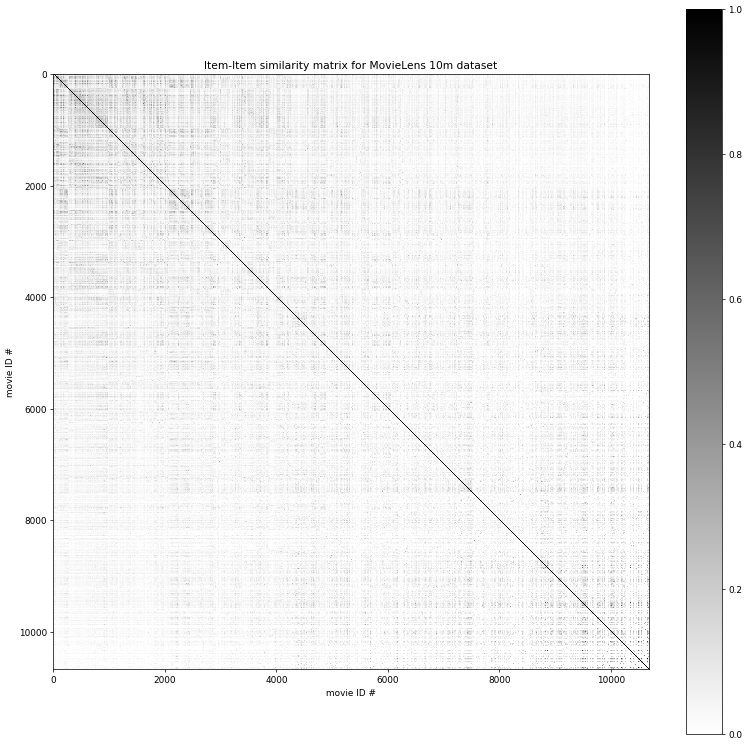

In [ ]:
plt.figure(figsize= (15,15), dpi = 64)
plt.imshow(movie_similarities,cmap = 'binary',interpolation='nearest')
plt.xlabel("movie ID #")
plt.ylabel("movie ID #")#, fontsize = 50)
plt.title("Item-Item similarity matrix for MovieLens 10m dataset")
plt.colorbar()

I was expecting there to be zero noticeable pattern in this initial plot since the only ordering is done by movie ID's, which I thought were chosen arbitrarily. Oddly enough, it appears that movies of with a lower ID number generally share more similarities than they do with higher ID number movies, and vice versa. 

I will try to coerce other patterns out of this similarity matrix by ordering the movies according to certain parameters, then repeating the item-item matrix plot given this ordering. General relationships between these similarities will become evident through color gradients in the heatmap, or obvious clustering.

I will try three different movie ordering methods, and afterwards analyze interactions between these parameters:

1) number of ratings. Movies that have received a lot of attention in the form of ratings may have higher similarity than movies that haven't

2) average rating. Movies with a similar high/low general rating may be more similar than those that don't

3) standard deviation of rating. Polarizing movies may have more in common with other polarizing movies.


First is ordering via number of ratings, in descending order

In [ ]:
#add movie frequency column to original dataset
ratings_filtered["movie_freq"] = ratings_filtered.groupby('movieId')['movieId'].transform('count')
ratings_temp = ratings_filtered.sort_values('movie_freq',ascending = False).reset_index(drop = True)

#run through same code as was done previously
m_rows = len(ratings_temp['userId'].unique())
n_cols = len(ratings_temp['movieId'].unique())


user_idx, user_unq = pd.factorize(ratings_temp['userId'])
movie_idx, movie_unq = pd.factorize(ratings_temp['movieId'])

moviecol = np.array(movie_idx)
userrow = np.array(user_idx)
values = np.array(ratings_temp['rating']) 

user_item_matrix = csr_matrix((values, (userrow,moviecol)),shape= (m_rows,n_cols))

#replaces old user item matrix with new ordered one (RAM is scarce so I need to continually replace it if it's no longer used)
movie_similarities = cosine_similarity(user_item_matrix.T)

C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\1615798886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_filtered["movie_freq"] = ratings_filtered.groupby('movieId')['movieId'].transform('count')


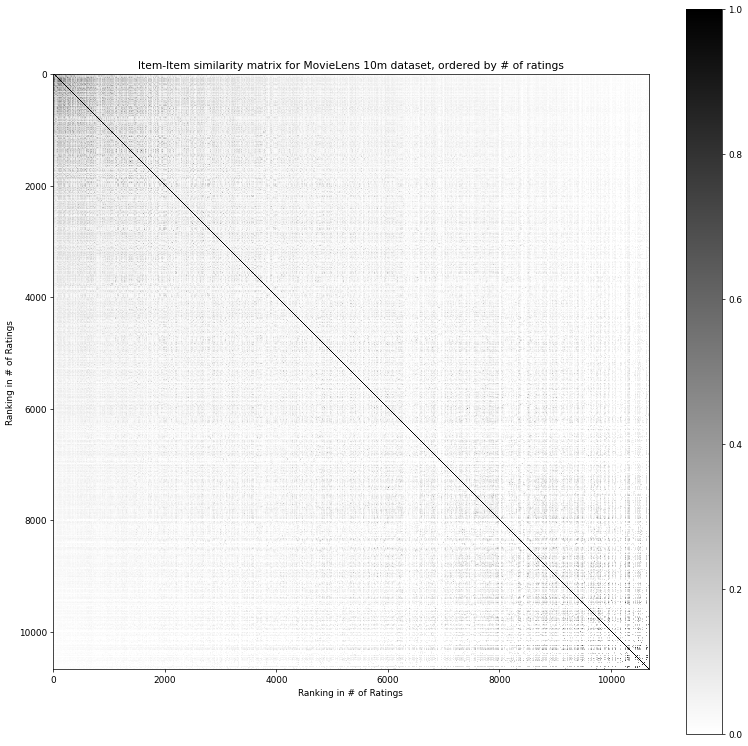

In [ ]:
plt.figure(figsize= (15,15), dpi = 64)
plt.imshow(movie_similarities,cmap = 'binary',interpolation='nearest')
plt.xlabel("Ranking in # of Ratings")
plt.ylabel("Ranking in # of Ratings")#, fontsize = 50)
plt.title("Item-Item similarity matrix for MovieLens 10m dataset, ordered by # of ratings")
plt.colorbar()

A clear gradient can be seen above, so there is some clear connection between the number of ratings and movie similarity, which would make sense.Generally speaking, well-known popular movies are more likely to have more in common with each other, as would lesser known, obscure films.

Next is ordering done based on Average movie rating

In [ ]:
# add average rating column to original data set
ratings_filtered["avg_rtg"] = ratings_filtered.groupby('movieId')['movieId'].transform('mean')
ratings_temp = ratings_filtered.sort_values('avg_rtg',ascending = False).reset_index(drop = True)

#run through same code as was done previously
m_rows = len(ratings_temp['userId'].unique())
n_cols = len(ratings_temp['movieId'].unique())


user_idx, user_unq = pd.factorize(ratings_temp['userId'])
movie_idx, movie_unq = pd.factorize(ratings_temp['movieId'])

moviecol = np.array(movie_idx)
userrow = np.array(user_idx)
values = np.array(ratings_temp['rating']) 

user_item_matrix = csr_matrix((values, (userrow,moviecol)),shape= (m_rows,n_cols))

#replaces old user item matrix with new ordered one (RAM is scarce so I need to continually replace it if it's no longer used)
movie_similarities = cosine_similarity(user_item_matrix.T)

C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\726040742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_filtered["avg_rtg"] = ratings_filtered.groupby('movieId')['movieId'].transform('mean')


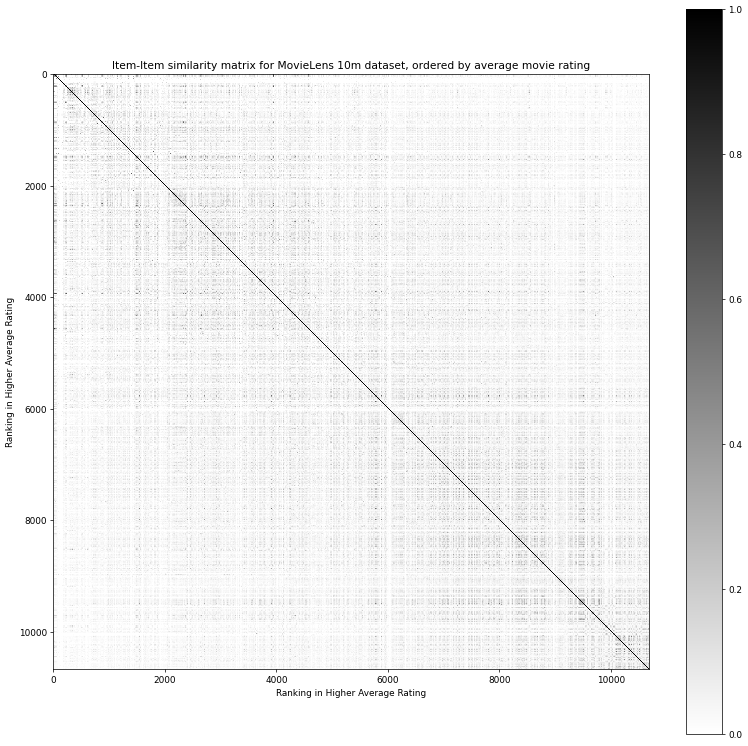

In [ ]:
plt.figure(figsize= (15,15), dpi = 64)
plt.imshow(movie_similarities,cmap = 'binary',interpolation='nearest')
plt.xlabel("Ranking in Higher Average Rating")
plt.ylabel("Ranking in Higher Average Rating")#, fontsize = 50)
plt.title("Item-Item similarity matrix for MovieLens 10m dataset, ordered by average movie rating")
plt.colorbar()

Overall there is not much of a visible pattern here, and the gradient is very muted. The bottom left and top right corners are whiter are a bit whiter than closer to the diagonal, but it's not much. I would say that average movie rating is generally a poor indication of how similar two movies are. Just because two movies are "good" doesn't mean they have anything in common.

Next is ordering done based on standard deviation

In [243]:
# add standard deviation rating column to original data set
ratings_filtered["std_rtg"] = ratings_filtered.groupby('movieId')['movieId'].transform('std')
ratings_temp = ratings_filtered.sort_values('std_rtg',ascending = False).reset_index(drop = True)

#run through same code as was done previously
m_rows = len(ratings_temp['userId'].unique())
n_cols = len(ratings_temp['movieId'].unique())


user_idx, user_unq = pd.factorize(ratings_temp['userId'])
movie_idx, movie_unq = pd.factorize(ratings_temp['movieId'])

moviecol = np.array(movie_idx)
userrow = np.array(user_idx)
values = np.array(ratings_temp['rating']) 

user_item_matrix = csr_matrix((values, (userrow,moviecol)),shape= (m_rows,n_cols))

#replaces old user item matrix with new ordered one (RAM is scarce so I need to continually replace it if it's no longer used)
movie_similarities = cosine_similarity(user_item_matrix.T)

C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\1281156737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_filtered["std_rtg"] = ratings_filtered.groupby('movieId')['movieId'].transform('std')


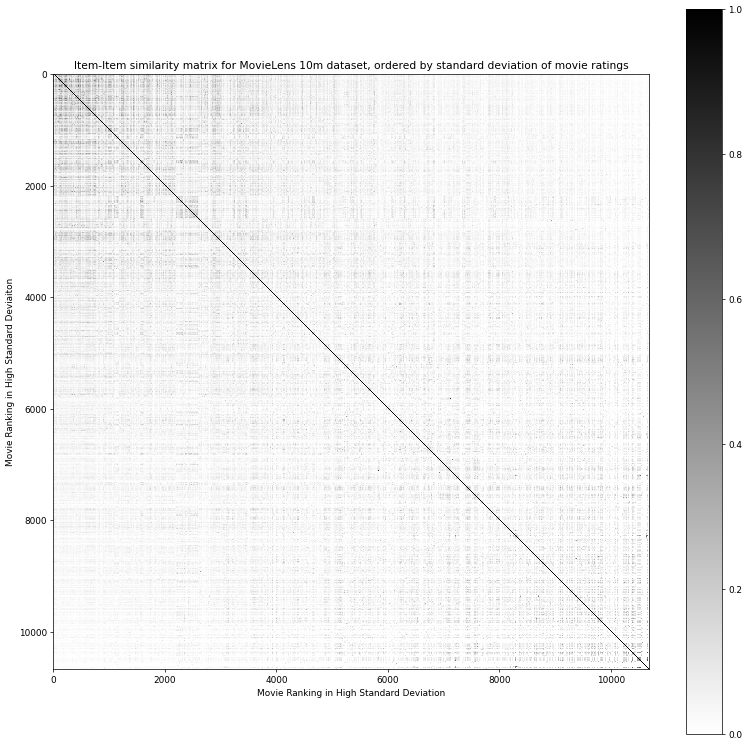

In [ ]:
plt.figure(figsize= (15,15), dpi = 64)
plt.imshow(movie_similarities,cmap = 'binary',interpolation='nearest')
plt.xlabel("Movie Ranking in High Standard Deviation")
plt.ylabel("Movie Ranking in High Standard Deviaiton")#, fontsize = 50)
plt.title("Item-Item similarity matrix for MovieLens 10m dataset, ordered by standard deviation of movie ratings")
plt.colorbar()

While there isn't a clear gradient around the diagonal line, one can still make out a dark "block" around the top 25th percentile of standard deviations at the top left. This would seem to suggest that movies with a clear split consensus share more similarities, but outside of that it doesn't have much of an influence. 

Now that those have been seen, it's time to investigate if there are any clear patterns between a movie's number of ratings, average rating, and rating standard deviation. Movie ID will be included, so as to possibly figure out why there was a pattern in the initial plot. This will be done with both a scatter matrix and a standard correlation matrix. 

In [ ]:
# creates the dataframe
moviegrouped = ratings_filtered.groupby("movieId")["rating"].count()
moviegrouped.name = "movie_rating_frequency"
mg_df = moviegrouped.to_frame().reset_index(drop=False)
mg_df["average_rating"] = ratings_filtered.groupby("movieId")['rating'].mean()
mg_df["std_of_ratings"] = ratings_filtered.groupby("movieId")['rating'].std()
mg_df["movieId"],_ = pd.factorize(mg_df['movieId']) 

Scatter Matrix plot with KDE

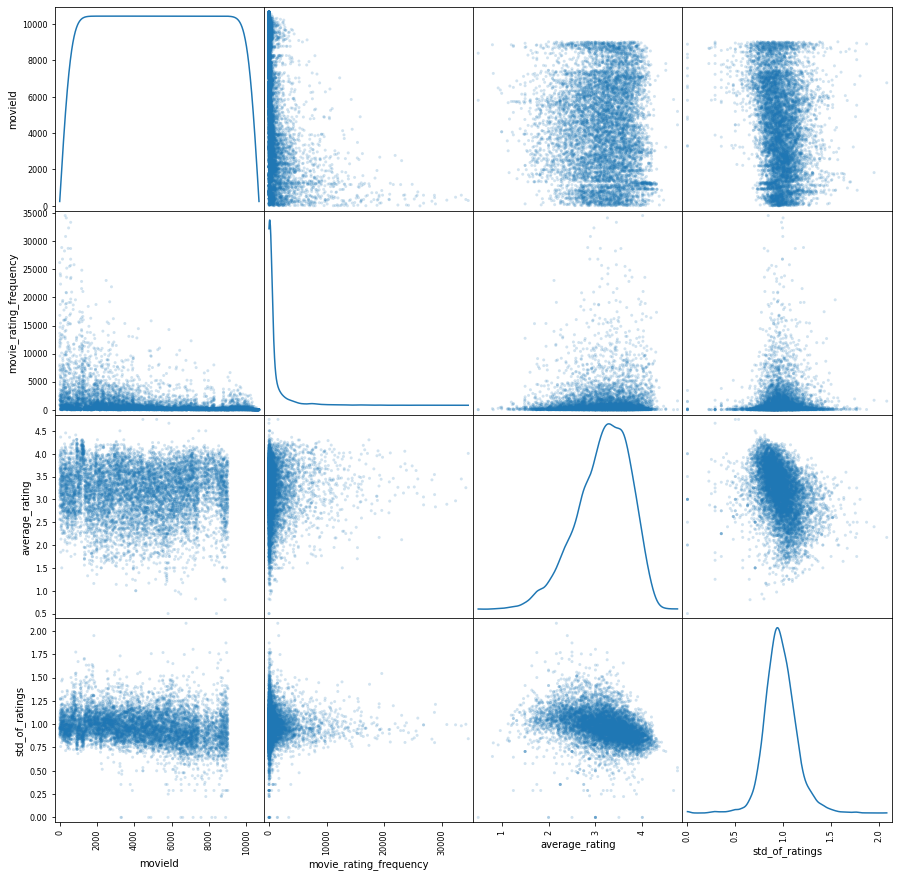

In [ ]:
pd.plotting.scatter_matrix(mg_df,alpha = 0.2,figsize=(15,15),diagonal="kde")
plt.show()

Correlation Matrix accompanying scatter matrix

In [ ]:
mg_df.corr()

,movieId,movie_rating_frequency,average_rating,std_of_ratings
movieId,1.000000,-0.341773,-0.021105,-0.217142
movie_rating_frequency,-0.341773,1.000000,0.051292,0.036731
average_rating,-0.021105,0.051292,1.000000,-0.352101
std_of_ratings,-0.217142,0.036731,-0.352101,1.000000


The two realtionships that stand out to me is the anticorrelation between the movie rating frequency and movieId, and the anticorrelation between the average rating and standard deviation of ratings.

The movieId and frequency relationship is probably just a byproduct of how the data was aggregated or assembled, but it does help explain why the initial similarity matrix had a gradient pattern to it. The corresponding scatterplot is mostly flat, but there is still a visible linear trend sloping downwards in the data.

The average rating and standard deviaiton of ratings relationship makes intuitive sense, since the average rating of movies with more of a "split concensus" will naturally become bogged down by their negative reviews.

The correlation matrix does identify anticorrelation between the movie id and standard deviation of ratings, but the scatter matrix is not very convincing for this. There's just a small handful of points with a standard deviation of zero at higher MovieIDs, which is probably an result of lower counts at higher ID's like previously mentioned.

With this done, the modelling can begin

# Models

The K-Nearest Neighbor learning models (both regression and searching) were chosen for this project, since the problem of collaborative filtering is a nearest-neighbors problem at it's core: "what is similar?" intuitively turns into a literal "what is closest?" problem when done given the right parameters. Although it becomes computationally expensive for large data sets, it scales well to large data, and although it can suffer from curse of dimensionality, it can remain an effective model when using metrics such as cosign similarity.

#### Model 1: KNN Regressor For Specific User Recommendations

The first model I will be trying is a K-nearest neighbors regressor via the scikit-learn library. 
 It is trained on 80% of the unmodified user item matrix's user entries, and the RMSE and MAE will be the evaluation metrics calculated for five separate n_neighbors values, 2, 4, 10, 50, and 100 as some simple hyperparameter tuning. Higher values were not tested due to the very high running time.

In [290]:
#creates an array for error so that RMSE and MAE can be calculated
pred_arr = []

# splits the data. It looks odd that there are only x-inputs, but since the data is already 
# in a multidimensional shape, it's fine to feed x_train to the model for both x and y, 
# since we're trying to use a limited number of users to predict the overall movie ratings for new users,
# based on the ratings of users in the test set.
X_train,X_test= train_test_split(user_item_matrix.toarray(), test_size = 0.2,random_state = 42)

# Varying the Hyperparameters
num_neighbors = [2,4,10,50,100]

for n in num_neighbors:
    #makes the model
    model = KNeighborsRegressor(n_neighbors=n,metric = 'cosine',n_jobs = -1)
    #fits the model
    model.fit(X_train,X_train)
    #makes the predictions
    preds = model.predict(X_test)
    
    pred_arr.append(preds)

Next the RMSE and MAE are calculated

In [291]:
rmse_regressor,mae_regressor = [],[]
x_compare = X_test.flatten()
for i in range(len(pred_arr)):
    pred = np.array(pred_arr[i]).flatten()
    err = (x_compare - pred)
    # removes entries where the model "correctly predicts" that the user hasn't seen the movie
    err = err[err != 0]
    rmse_regressor.append(np.sqrt(np.mean((err)**2)))
    mae_regressor.append(np.mean(np.abs(err)))

A dummy reference model is made, one that just returns the average movie rating of the training set when attempting to predict movie ratings for the test set.   

In [299]:
mean_x_train = np.mean(X_train.flatten()[X_train.flatten() !=0])

x_test_m = np.array(X_test.flatten()[X_test.flatten() !=0])

err_test = x_test_m - mean_x_train

dummy_rmse = np.sqrt(np.mean((err_test)**2))
dummy_mae = np.mean(np.abs(err_test))



RMSE of dummy model is 1.057
MAE of dummy model is 0.851


#### Model 1 results: KNN Regressor For Specific User Recommendations

These are the results for the KNN regressor model, using Root Mean Squared Error and Mean Absolute Error as the evaluation metrics.

In [300]:
for n in range(len(num_neighbors)):
    print("For {} neighbors, RMSE is {:.3f}, and MAE is {:.3f}".format(num_neighbors[n],rmse_regressor[n],mae_regressor[n]))
print("For Dummy Model, RMSE is {:.3f}, MAE is {:.3f}".format(dummy_rmse,dummy_mae))


For 2 neighbors, RMSE is 2.255, and MAE is 1.962
For 4 neighbors, RMSE is 1.754, and MAE is 1.430
For 10 neighbors, RMSE is 1.340, and MAE is 0.963
For 50 neighbors, RMSE is 0.919, and MAE is 0.507
For 100 neighbors, RMSE is 0.799, and MAE is 0.393
For Dummy Model, RMSE is 1.057, MAE is 0.851


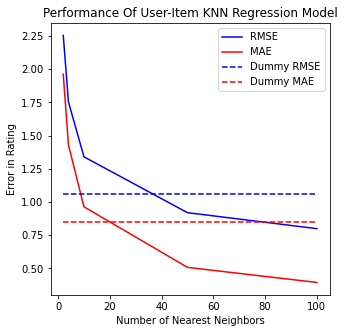

In [311]:
num_neighbors = [2,4,10,50,100]
plt.figure(figsize=(5,5))
plt.plot(num_neighbors,rmse_regressor,c = "blue", label = "RMSE")
plt.plot(num_neighbors,mae_regressor,c = "red",label = "MAE")
plt.hlines(dummy_rmse,num_neighbors[0],num_neighbors[-1],
           colors = "blue",linestyles="--",label= "Dummy RMSE")
plt.hlines(dummy_mae,num_neighbors[0],num_neighbors[-1],
           colors = "red",linestyles="--",label= "Dummy MAE")

#plt.ylim(0,0.5)
plt.title("Performance Of User-Item KNN Regression Model")


plt.xlabel("Number of Nearest Neighbors")
plt.ylabel("Error in Rating")

plt.legend()

Here we can see that the performance of the model changed quite a bit when we upped the number of neighbors. Unfortunately the model could not be tested for even higher values of KNN
At 100 neighbors there was the lowest RMSE of 0.799, with an MAE of 0.393

Overall I would say that these results are mixed. While an RMSE of 0.8 might sound good at first, it's underwhelming considering that the dummy model that just output the average rating as its "prediction" was able to get an RMSE of 1.06.

However, the model was able to acheive a solid value of 0.393 for MAE, which is less than half of that done using the dummy model, which is a solid improvement. The high RMSE to MAE ratio suggests that despite the model being able to capture the general ratings of users well, it lacks nuance. When the model does miss it completely misses the mark, predicting high ratings when the actual is low, and low ratings when the actual is high. The dummy model has a comparable rms since while it does get things wrong often, since the predicted rating is the movie average, it can never be wrong by a large amount like the KNN model can.

# Model 2 KNN Search For Similar Movies
For this model, I implement a K-Nearest Neighbors Search algorithm on the item-item matrix. The core of the model is to just return the most "similar" entries in the item-item matrix based on their vectors.

 In order to evaluate the effectiveness of this model, the search algorithm will be used to predict the similarity scores that the item has within its column, based on the weighted average of "nearest" items' columns. 

In [335]:
def predict_sim_ii(X_train,X_test,num_neighbors):
    
    # Train model on training set
    model = NearestNeighbors(n_neighbors=num_neighbors, metric='cosine',n_jobs=-1)
    #fits model
    model.fit(X_train)
    # Retrieve k nearest neighbors within the train set for each item in the test set
    distances, indices = model.kneighbors(X_test, n_neighbors=n)
    # Predict ratings for test set based on weighted average using similarities
    preds = []
    for i in range(len(X_test)):
        # pulls movie ratings and similarities for nearest neighbors
        neighbor_ratings = X_train[indices[i]]
        similarities = distances[i]
        # performs a  weighted average on ratings, using similarities as the weights
        weighted_sum = np.dot(similarities, neighbor_ratings)
        sum_similarities = np.sum(similarities)
        #adds to list
        preds.append(weighted_sum/sum_similarities)

    # convert to numpy array
    preds = np.array(preds)
    # turns truedivide errors to zero
    preds = np.nan_to_num(preds)
    return preds
#calculates the rms for a nested list of predictions made by predict_sim_ii
def rmse_list(pred,X_test):
    list_rms = []
    for p in pred:
        pred_c = p.flatten()
        list_rms.append(np.sqrt(mean_squared_error(pred_c,X_test.flatten())))
    return list_rms    
#does the same for mae
def mae_list(pred,X_test):
    list_mae = []
    for p in pred:
        pred_c = p.flatten()
        list_mae.append(mean_absolute_error(pred_c,X_test.flatten()))
    return list_mae    

Predictions are now performed for a few different n neighbors to tune the model

In [353]:
num_neighbors = [2,4,8,16,32,64]

item_item_matrix = cosine_similarity(user_item_matrix.T)

X_train,X_test = train_test_split(item_item_matrix, test_size=0.2, random_state= 42)

base_pred = []
for n in num_neighbors:
    pred = predict_sim_ii(X_train,X_test,n)   
    base_pred.append(pred)

C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\2128915965.py:19: RuntimeWarning: invalid value encountered in true_divide
  preds.append(weighted_sum/sum_similarities)
C:\Users\Angel\AppData\Local\Temp\ipykernel_2360\2128915965.py:19: RuntimeWarning: invalid value encountered in true_divide
  preds.append(weighted_sum/sum_similarities)


In [343]:
print(np.count_nonzero(item_item_matrix.flatten())/len(item_item_matrix.flatten()))

0.8559953841681796


Before the RMSE and MAE is evaluated, it should be established what a "good" value is for the similarity RMSE and MAE, since although the similarities do have a definite range from 0 to 1, that may not be indicative of the actual scores. This will just be done qualitatively with a histogram.

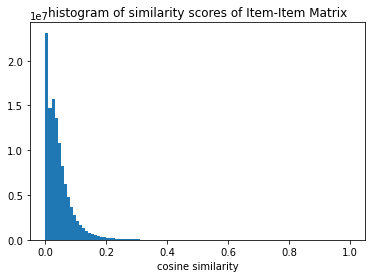

In [356]:
plt.hist(item_item_matrix.flatten(),bins = 100)
plt.title("histogram of similarity scores of Item-Item Matrix")
plt.xlabel("cosine similarity")
plt.show()

Here we see that the bulk of similarity scores are very small, and that there are very few going beyond 0.2. Given this, we probably want our model to have an error about 10% of that, so around 0.02.

In [354]:
rmse_base = rmse_list(base_pred,X_test)
mae_base = mae_list(base_pred,X_test)

for n in range(len(num_neighbors)):
    print("For {} neighbors, RMSE is {:.4f}, and MAE is {:.4f}".format(num_neighbors[n],rmse_base[n],mae_base[n]))

For 2 neighbors, RMSE is 0.0250, and MAE is 0.0148
For 4 neighbors, RMSE is 0.0237, and MAE is 0.0145
For 8 neighbors, RMSE is 0.0235, and MAE is 0.0146
For 16 neighbors, RMSE is 0.0238, and MAE is 0.0151
For 32 neighbors, RMSE is 0.0245, and MAE is 0.0158
For 64 neighbors, RMSE is 0.0253, and MAE is 0.0166


Text(0.5, 0, 'num_neighbors')

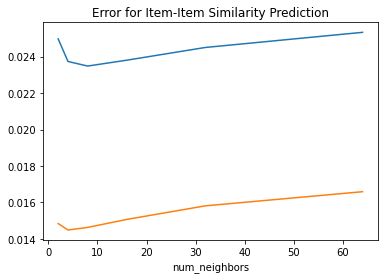

In [355]:
plt.plot(num_neighbors,rmse_base,label = "RMSE of base model")
plt.plot(num_neighbors,mae_base,label = "MAE of base model")
plt.title("Error for Item-Item Similarity Prediction")
plt.xlabel("num_neighbors")


It appears that the model did well in predicting similarities between the data.

At 4 neighbors it had an RMSE of 0.0237, and it's lowest MAE of 0.0145

At 8 neighbors it had it's lowest RMSE of 0.0235, and a MAE of 0.0146

It generally performed worse with a higher number of neighbors, since doing so can smooth over some of the more important features

With the unaltered "base" model now made, there will be some implementation of feature engineering to test the importance of the two potentially key features of the data that were identified during the exploratory data analysis: the number of ratings, and the standard deviation of ratings.

In order to do this, a naive implementation of feature permutation performance will be performed, which is to remove the feature from the training data, and see how it affects it's performance metrics. The higher the drop in performance with the feature removed, the more important it was to the model. 

To "remove" rating counts, Weights will be implemented in the item-item matrix, dividing column vectors by the inverse of that movie's rating count. Doing so to the user-item matrix does nothing, since cosine similarity is calculated based on angles, not distances.

To "remove" standard deviation, the ratings for each individual movie will be scaled, such that the standard deviation of that particular movie's ratings will equal 1, which is the average standard deviation for the movies.

 A typical, proper implementation of permutation performance would be to randomly shuffle a particular feature within data and observe the model's decline, but this approach doesn't make much sense given that these features are "baked into" the data. Of course randomly varying the standard deviation of particular movie similarities, or the weights of its' similarities will make this particular model perform worse.

In [381]:
print(item_weights.shape)
print(user_item_matrix_w.shape)

(10675,)
(69057, 10675)


In [409]:
num_neighbors = [2,4,8,16,32,64]
# creates item-item matrix for "weightless" model

# create weights based on the count of items
item_weights = 1/np.asarray(user_item_matrix.astype(bool).sum(axis = 0)).squeeze()
item_diag = np.diag(item_weights)
# create weighted user item matrix
item_item_weightless = np.matmul(item_item_matrix,item_diag)




# creates item-item matrix for "normalized" model

#defines the standard deviation for each movie ID's rating
std_for_each = ratings_filtered.groupby("movieId")["rating"].transform("std")
# creates new normalized rating parameter
ratings_filtered["rating_normalized"] = (ratings_filtered["rating"]/ std_for_each)
values = np.array(ratings_filtered['rating_normalized']) 
# normalized usre-item matrix
user_item_matrix_normalized = csr_matrix((np.nan_to_num(values), (userrow,moviecol)),shape= (m_rows,n_cols))
# normalized item-item matrix
item_item_normalized = cosine_similarity(user_item_matrix_normalized.T)

c:\Users\Angel\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [411]:
# models are trained on the "weightless" values, and tested on the unmodified values 
# this is done for the same nearest neighbors as the base model 
X_train,X_test,X_train_weighted,X_test_weighted = train_test_split(item_item_matrix,item_item_weightless, test_size=0.2, random_state= 42)
wt_pred = []
for n in num_neighbors:
    pred = predict_sim_ii(X_train_weighted,X_test,n)   
    wt_pred.append(pred)

In [412]:
# models are trained on the "normalized" values, and tested on the unmodified values 
# this is done for the same nearest neighbors as the base model 
X_train,X_test,X_train_normalized,X_test_normalized = train_test_split(item_item_matrix,item_item_normalized, test_size=0.2, random_state= 42)
norm_pred = []
for n in num_neighbors:
    pred = predict_rating_ii(X_train_normalized,X_test,n)   
    norm_pred.append(pred)

With the models now made, they can be evaluated

In [413]:
rmse_wt = rmse_list(wt_pred,X_test)
mae_wt = mae_list(wt_pred,X_test)

rmse_norm = rmse_list(norm_pred,X_test)
mae_norm = mae_list(norm_pred,X_test)

In [416]:
for n in range(len(num_neighbors)):
    print("For weightless model with {} neighbors, RMSE is {:.4f}, and MAE is {:.4f}".format(num_neighbors[n],rmse_wt[n],mae_wt[n]))

For weightless model with 2 neighbors, RMSE is 0.0621, and MAE is 0.0429
For weightless model with 4 neighbors, RMSE is 0.0621, and MAE is 0.0429
For weightless model with 8 neighbors, RMSE is 0.0621, and MAE is 0.0429
For weightless model with 16 neighbors, RMSE is 0.0621, and MAE is 0.0429
For weightless model with 32 neighbors, RMSE is 0.0621, and MAE is 0.0429
For weightless model with 64 neighbors, RMSE is 0.0621, and MAE is 0.0429


In [417]:
for n in range(len(num_neighbors)):
    print("For normalized model with {} neighbors, RMSE is {:.4f}, and MAE is {:.4f}".format(num_neighbors[n],rmse_norm[n],mae_norm[n]))

For normalized model with 2 neighbors, RMSE is 0.0283, and MAE is 0.0172
For normalized model with 4 neighbors, RMSE is 0.0272, and MAE is 0.0169
For normalized model with 8 neighbors, RMSE is 0.0270, and MAE is 0.0171
For normalized model with 16 neighbors, RMSE is 0.0272, and MAE is 0.0174
For normalized model with 32 neighbors, RMSE is 0.0277, and MAE is 0.0181
For normalized model with 64 neighbors, RMSE is 0.0285, and MAE is 0.0188


In [ ]:
plt.plot(num_neighbors,rmse_base)
plt.plot(num_neighbors,mae_base)


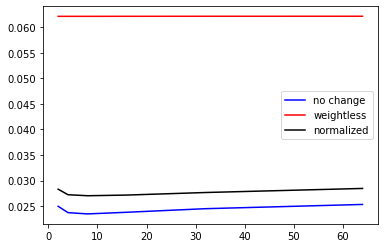

In [414]:
plt.plot(num_neighbors,rmse_base,c = "blue",label = "no change")
plt.plot(num_neighbors,rmse_wt, c = "red", label = "weightless")
plt.plot(num_neighbors,rmse_norm, c = "black", label = "normalized")
plt.legend()

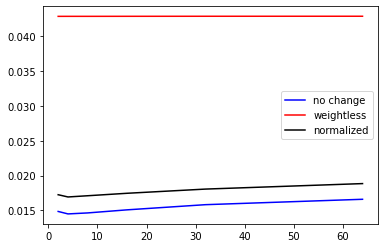

In [418]:
plt.plot(num_neighbors,mae_base,c = "blue",label = "no change")
plt.plot(num_neighbors,mae_wt, c = "red", label = "weightless")
plt.plot(num_neighbors,mae_norm, c = "black", label = "normalized")
plt.legend()

Here we see clear declines in both models, with the weightless model now considerably worse than before, and the normalized model only slightly worse than before. This agrees with the patterns seen during the exploratory data analysis, that movie "popularity" in the form of ratings, would contribute greatly to the model, and that the standard deviation as a measure of how "polarizing" a movie is, has a slight contribution to the model.

Now that the model's accuracy and feature importances have been verified, it's time to use it for it's intended purpose, recommending movies. 

Recently I watched an Arnold Schwarzenegger movie called "Total Recall" that I enjoyed, so I'm hoping to get some good recommendations.

In [431]:
Num_recs = 10  + 1 # first recommendation will always be input movie, so needs one extra
#creates model
iimodel = NearestNeighbors(metric = "cosine", algorithm= "brute",n_neighbors=Num_recs)
#fits model to the item_item matrix
iimodel.fit(item_item_matrix)


#input movie here!
input = "Total Recall (1990)"#"Rocky (1976)"#"Total Recall (1990)"#"Terminator, The (1984)"#

#converts to the movie ID used in the movies csv
index_c = movies["movieId"][movies['title'] == input].tolist()[0]
#creates list of movie indexes used by model
movie_i = np.arange(len(movie_unq))
# finds the movie index on the model based on movie ID
item_id = movie_i[movie_unq == index_c]

# gets model indices of nearest neighbors
__,indices = iimodel.kneighbors(movie_similarities[item_id,:].reshape(1,-1))
similar_item_id = indices.flatten().tolist()[1:]

print("If you liked {}, you may like...".format(movies["title"][movies["movieId"]==index_c].tolist()[0]))
for i in range(len(similar_item_id)):
    #converts to movie ID
    id_preadj = similar_item_id[i]
    idx_test = movie_unq[id_preadj]
    #converts to output movie title
    print(movies["title"][movies["movieId"]==idx_test].tolist()[0])

If you liked Total Recall (1990), you may like...
RoboCop (1987)
Terminator, The (1984)
Abyss, The (1989)
Aliens (1986)
Starship Troopers (1997)
Lethal Weapon (1987)
Hunt for Red October, The (1990)
Face/Off (1997)
Star Wars: Episode I - The Phantom Menace (1999)
Men in Black (1997)


The first five of these are all actually pretty good recommendations for Total Recall. Not only they all scifi action movies, but there are some important similarites they contain as well:

- Both RoboCop and Starship Troopers have the same director as Total Recall, Paul Verhoeven

- The Terminator and Total Recall have the same lead actor, Arnold Schwarzenegger

- The director of Aliens and The Abyss, James Cameron, also directed The Terminator

Beyond these however, while they may share general similarities such as "scifi" or "action", they aren't very similar to the original movie. I've tried this a few times, and usually after a handful of good recommendations, they start to get vague in their relevance.

# Discussion and conclusion

Overall I am happy with how the models turned out, but they are not without their issues.

 I learned that the user-item knn regression model generalizes well, but can often fail to provide nuance in its predictions. These missed predictions are often on the completely separate end of the ratings' scale, leading to outliers in the error and a high RMSE. It makes sense why the user-item regression model would lack nuance, because it was a regression model was being fit to data that was lacking in nuance. Naturally it would fit to an "average"-type rating when predicting user ratings for a movie, and get that rating terribly wrong for polarizing movies, whose ratings had nuance to them. If I wanted to implement an improved user-item collaborative filtering model, I would probably use a user-user matrix model, to identify similarities between users, and use the most similar users' ratings as predictions, and their favorite movies as recommendations. Unfortunately this model would be _very_ computationally intensive, having a 71,000X71,000 user-user matrix for this dataset, so a smaller dataset would have to be used.

 I learned that while the item-item knn model can provide accurate movie recommendations, movie popularity (in the form of rating count) plays a very large role in it's recommendation system. The model ultimately gives a higher priority to more popular movies, even if a less popular one would be a better fit. This could ultimately be improved by adding more parameters to the model for it to fit and compare, such as applying the lists of user-generated tags to their movies, and factoring these into the similarity calculation as well. Not only this, but a hybrid approach with both item-item and user-user generated movies may provide more unique and interesting recommendations beyond the obvious ones.

## Citations
_F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History
and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4,
Article 19 (December 2015), 19 pages._

DOI=http://dx.doi.org/10.1145/2827872